# 🧠 Clasificador de Estado de Salud con PyTorch

Este proyecto utiliza una red neuronal profunda (MLP) implementada en PyTorch para clasificar el estado de salud de pacientes en tres categorías: **mala**, **regular** o **buena**, usando un conjunto de datos tabulares.

---


## Importar librerias

In [1]:
# Manejo de datos
import numpy as np
import pandas as pd
import random
import os

# Modelos de Deep Learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#Preprocesamiento de datos
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Gráficos
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Configuración warnings (Quitar en caso de errores desconocidos)
import warnings
warnings.filterwarnings('ignore')

# Versión de paquetes usados
color = '\033[1m\033[38;5;208m'
print(f"{color}Versión de las librerias utilizadas:")
print(f"{color}- Version torch: {torch.__version__}")
print(f"{color}- Version pandas: {pd.__version__}")
print(f"{color}- Version numpy: {np.__version__}")
print(f"{color}- Version sklearn: {pd.__version__}")

Versión de las librerias utilizadas:
- Version torch: 2.7.0+cpu
- Version pandas: 2.2.3
- Version numpy: 2.2.6
- Version sklearn: 2.2.3


## Lectura del dataset

In [2]:
try:
    data = pd.read_csv('Datasets\diabetes_012_health_indicators_BRFSS2015.csv')
    print("Archivo cargado correctamente.")
except Exception as e:
    print(f"Error: {e}")

Archivo cargado correctamente.


In [3]:
data.head(5)

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [5]:
seed = 110425
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
#Resample
class_0 = data[data['Diabetes_012'] == 0].sample(n=4631, random_state=42) 
class_1 = data[data['Diabetes_012'] == 1].sample(n=4631, random_state=42) 
class_2 = data[data['Diabetes_012'] == 2].sample(n=4631, random_state=42) 
balanced_train_data = pd.concat([class_0, class_1, class_2]).sample(frac=1, random_state=42).reset_index(drop=True)


In [7]:
balanced_train_data.head(5)

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,2.0,0.0,0.0,1.0,27.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,4.0,5.0,15.0,1.0,0.0,10.0,2.0,2.0
1,0.0,0.0,1.0,1.0,28.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,4.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
3,1.0,1.0,1.0,1.0,29.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,1.0,11.0,5.0,8.0
4,2.0,1.0,1.0,1.0,33.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,3.0,0.0,2.0,0.0,0.0,8.0,4.0,8.0


In [8]:
balanced_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13893 entries, 0 to 13892
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_012          13893 non-null  float64
 1   HighBP                13893 non-null  float64
 2   HighChol              13893 non-null  float64
 3   CholCheck             13893 non-null  float64
 4   BMI                   13893 non-null  float64
 5   Smoker                13893 non-null  float64
 6   Stroke                13893 non-null  float64
 7   HeartDiseaseorAttack  13893 non-null  float64
 8   PhysActivity          13893 non-null  float64
 9   Fruits                13893 non-null  float64
 10  Veggies               13893 non-null  float64
 11  HvyAlcoholConsump     13893 non-null  float64
 12  AnyHealthcare         13893 non-null  float64
 13  NoDocbcCost           13893 non-null  float64
 14  GenHlth               13893 non-null  float64
 15  MentHlth           

In [17]:
x = balanced_train_data.drop(columns=["Diabetes_012"]).to_numpy() # Datos de entrenamiento
y = balanced_train_data["Diabetes_012"].to_numpy()
scaler = StandardScaler()
x = scaler.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

In [18]:
#Formato correcto
#Train
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

#Val
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

#Test
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [19]:
batchsize = 32
class DiabetesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_data = DiabetesDataset(X_train, y_train)
val_data = DiabetesDataset(X_val, y_val)
test_data = DiabetesDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batchsize, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batchsize, shuffle=False)

In [12]:
len(train_data)

10628

In [13]:
#Definamos un modelo para trabajar
#Vamos a hacerlo más complejo de lo necesario

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.hc1 = nn.Linear(21, 256)
        self.hc2 = nn.Linear(256, 128)
        self.hc3 = nn.Linear(128, 64)
        self.hc4 = nn.Linear(64, 3)
        #self.act = nn.ELU()
        self.act = nn.LeakyReLU()
        #self.act = nn.ReLU()
        self.dp1 = nn.Dropout(0.4)
        self.dp2 = nn.Dropout(0.2)

    def forward(self, input):
        l1 = self.dp1(self.act(self.hc1(input)))
        l2 = self.dp2(self.act(self.hc2(l1)))
        #l1 = self.act(self.hc1(input))
        #l2 = self.act(self.hc2(l1))
        l3 = self.act(self.hc3(l2))
        output = self.hc4(l3)
        return output

In [ ]:
testeo = MLP()
#lr = 1e-4
#opt = torch.optim.Adam(testeo.parameters(), lr=lr, weight_decay=1e-4)
# lr = 1e-3
# opt = torch.optim.SGD(testeo.parameters(), lr=lr, weight_decay=1e-4)
# lr = 1e-4
# opt = torch.optim.RMSprop(testeo.parameters(), lr=lr, weight_decay=1e-4)
loss_func = nn.CrossEntropyLoss()

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=10)


In [20]:
lambda_l1 = 1e-3
def l1_penalty(model):
    l1 = 0.0
    for param in model.parameters():
        #l1 += param.abs().sum() #si cambiaramos abs() por pow(2.0) tendriamos L2
        if param.requires_grad and len(param.shape) > 1:
            l1 += torch.norm(param, p=1)
    return l1

In [ ]:
#Entrenamiento
lr = 1e-4
opt = torch.optim.Adam(testeo.parameters(), lr=lr, weight_decay=1e-4)

n_epochs = 200
history = {
    "TL" : [],
    "VL" : []
}
early_stopping = {
    "delta" : 1e-5,
    "patience": 50
}
best_val_loss = float("inf")
aux = 0

for i in range(n_epochs+1):
    testeo.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:  
      output = testeo(X_batch)
      loss = loss_func(output, y_batch)  #+ l1_penalty(testeo) *lambda_l1
      #scheduler.step(loss)
      
      opt.zero_grad()
      loss.backward()
      opt.step()

      epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    history["TL"].append(epoch_loss)

    testeo.eval()
    epoch_loss = 0
    for X_batch, y_batch in val_loader:
      with torch.no_grad():
        preds_val = testeo(X_batch)
      val_loss = loss_func(preds_val, y_batch)

      epoch_loss += val_loss.item()
    epoch_loss /= len(val_loader)
    history["VL"].append(epoch_loss)
    
    if epoch_loss + early_stopping["delta"] < best_val_loss:
      best_val_loss = epoch_loss
      aux = 0
    else:
      aux += 1
      if aux >= early_stopping["patience"]:
        print(f"Terminando el entrenamiento en la época {i}")
        break
    

Terminando el entrenamiento en la época 130


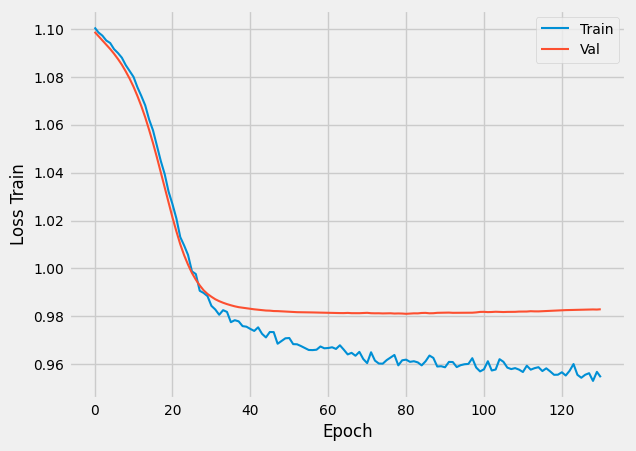

In [49]:

plt.plot(history["TL"], label="Train")
plt.plot(history["VL"], label="Val")
plt.xlabel('Epoch')
plt.ylabel('Loss Train')
plt.legend()
plt.show()

In [50]:
#Train
with torch.no_grad():
    output_train = testeo(X_train)
y_hat_train = output_train.numpy()
y_hat_train = [np.argmax(i) for i in y_hat_train]
print(f'Training Accuracy: {accuracy_score(y_train, y_hat_train):.2f}')
#Testeo
with torch.no_grad():
    output = testeo(X_test)  
y_hat = output.numpy()
y_hat = [np.argmax(i) for i in y_hat]
print(f'Testing Accuracy: {accuracy_score(y_test, y_hat):.2f}')

Training Accuracy: 0.53
Testing Accuracy: 0.52


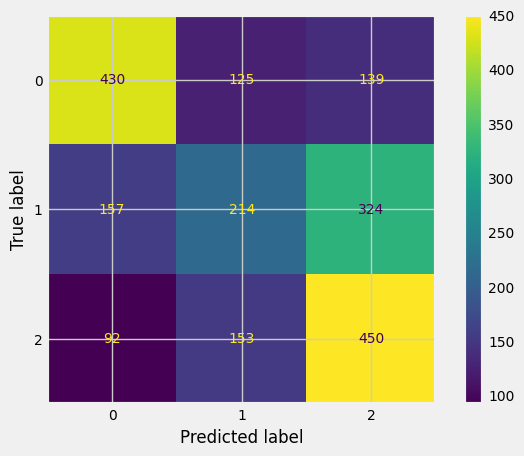

In [51]:
cm =confusion_matrix(y_test, y_hat)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_plot.plot()
plt.show()

In [ ]:
cat_cols = ["Gender", "Smoker", "Diabetic", "Heart_Disease"]
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

IndexError: too many indices for tensor of dimension 2

In [34]:
cols = ['Age', 'BMI', 'Daily_Steps', 'Calories_Intake', 'Hours_of_Sleep', 'Estado_Salud']
sns.pairplot(data[cols], hue='Estado_Salud', diag_kind='kde', corner=True)
plt.show()

KeyError: "['Daily_Steps', 'Calories_Intake', 'Hours_of_Sleep', 'Estado_Salud'] not in index"